In [6]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import alen, arange
import math
from math import sqrt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, KFold, train_test_split
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Import PySwarms
import pyswarms as ps


#### PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler




In [7]:
#BPSO

def pls_optimise_components(X, y, npc):
 
    rmsecv = np.zeros(npc)
    for i in range(1,npc+1,1):
 
        # Simple PLS
        pls_simple = PLSRegression(n_components=i)
        # Fit
        pls_simple.fit(X, y)
        #cv = LeaveOneOut()
        cv=10
        # Cross-validation
        y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
        # Calculate scores
        score = r2_score(y, y_cv)
        rmsecv[i-1] = np.sqrt(mean_squared_error(y, y_cv))
 
    # Find the minimum of ther RMSE and its location
    opt_comp, rmsecv_min = np.argmin(rmsecv),  rmsecv[np.argmin(rmsecv)]
 
    return (opt_comp+1, rmsecv_min)

def base_pls(X,y,n_components, return_model=False):
 
    # Simple PLS
    pls_simple = PLSRegression(n_components=n_components)
    # Fit
    pls_simple.fit(X, y)
    #cv = 10
    cv= 10
    # Cross-validation
    y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
    # Calculate scores
    score = r2_score(y, y_cv)
    rmsecv = np.sqrt(mean_squared_error(y, y_cv))
 
    if return_model == False:
        return(y_cv, score, rmsecv)
    else:
        return(y_cv, score, rmsecv, pls_simple)
    

# Create an instance 
#reg = linear_model.LinearRegression

# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    
    total_features = dimensions
    # Get the subset of the features from the binary mask

    #X_sav = savgol_filter(X_train, 3, polyorder=2, deriv=1)

    if np.count_nonzero(m) == 0:
        X_subset = X_train
    else:
        X_subset = X_train[:,m==1]

    
 

    # #regr = make_pipeline(StandardScaler(), SVR())
    # #regr = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=5, random_state=1))
    # #regr = make_pipeline(StandardScaler(), SVR(C = 0.5, degree= 1, kernel= 'rbf',epsilon= 0.16))
    # #X1 = savgol_filter(X_subset, 3, polyorder=2, deriv=1)
    # reg1 = GradientBoostingRegressor(random_state=1)
    # reg2 = RandomForestRegressor(random_state=1)
    # reg3 = LinearRegression()
    # ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
    # ereg = ereg.fit(X_subset, y_train_oleo)
    # #regr.fit(X_subset, y_train_oleo)
    # #y_pred = cross_val_predict(regr, X_subset, y_train_oleo, cv=10)
    # y_pred = ereg.predict(X_subset)
    # #y_pred = regr.predict(X1)
    # r2cv = mean_squared_error(y_train_oleo, y_pred)
    # #r2cv = r2_score(y_train_oleo, y_pred)
    # P = r2cv
    # #P = (classifier.predict(X_subset) == y).mean()
    # # Compute for the objective function
    # j = (alpha * (1.0 - (1-P))
    #     + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    # regr = make_pipeline(StandardScaler(), SVR())
    # #regr = make_pipeline(StandardScaler(), SVR(C = 0.5, degree= 1, kernel= 'rbf',epsilon= 0.16))
    # #X1 = savgol_filter(X_subset, 3, polyorder=2, deriv=1)

    # #regr.fit(X1, y_train_oleo)
    # y_pred = cross_val_predict(regr, X_subset, y_train_oleo, cv=10)
    # #y_pred = regr.predict(X1)
    # #r2cv = mean_squared_error(y_train_oleo, y_pred)
    # r2cv = r2_score(y_train_oleo, y_pred)
    # P = r2cv
    # #P = (classifier.predict(X_subset) == y).mean()
    # # Compute for the objective function
    # j = (alpha * (1.0 - P)
    #     + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))



    opt_comp, rmsecv_min = pls_optimise_components(X_subset, y_train_oleo, 5)
    predicted, r2cv, rmscv = base_pls(X_subset, y_train_oleo, opt_comp)
    
    P = r2cv
    #P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

def msc(input_data):
     # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    

    # Calculate mean
    ref = np.mean(input_data, axis=0)

 
    # Define a new array and populate it with the corrected data    
    output_data= np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return output_data

In [8]:
df = pd.read_excel('Data/Cacao/NIRS spectrum Cocoa Beans.xlsx', skiprows=[0,1,2,3,4,5])

In [9]:
df.head()

,sample Num,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,...,2483.5,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,Moisture Content (%),Fat Content (%)
0,1,0.455245,0.455134,0.454986,0.455009,0.454722,0.454652,0.454516,0.454527,0.454581,...,1.240786,1.244121,1.246720,1.249081,1.250945,1.252397,1.253387,1.254267,8.17,39.11000
1,2,0.485282,0.485407,0.485407,0.485478,0.485399,0.485284,0.485150,0.485174,0.485439,...,1.263340,1.266759,1.269205,1.271461,1.273356,1.274930,1.276129,1.277142,7.52,39.14000
2,3,0.504128,0.503784,0.503550,0.503983,0.503992,0.503576,0.503656,0.503647,0.503327,...,1.298061,1.301578,1.304317,1.306653,1.308487,1.310115,1.310987,1.311702,8.52,42.35439
3,4,0.470077,0.469761,0.469780,0.469852,0.469783,0.469600,0.469520,0.469439,0.469648,...,1.240584,1.243668,1.246182,1.248631,1.250560,1.252181,1.253309,1.254296,8.65,42.71632
4,5,0.495356,0.495335,0.495513,0.495504,0.495303,0.495128,0.495118,0.495339,0.495136,...,1.300846,1.304284,1.306948,1.309266,1.311007,1.312586,1.313464,1.314298,7.66,38.57000


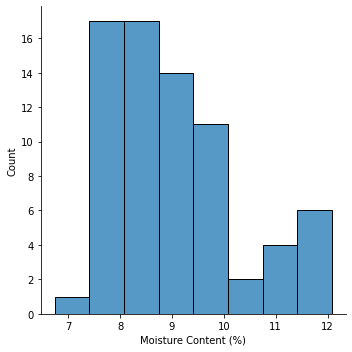

In [5]:
import seaborn as sns
sns.displot(df['Moisture Content (%)'])

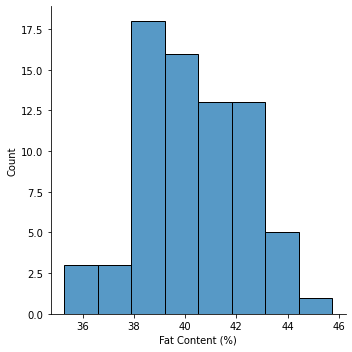

In [6]:
import seaborn as sns
sns.displot(df['Fat Content (%)'])

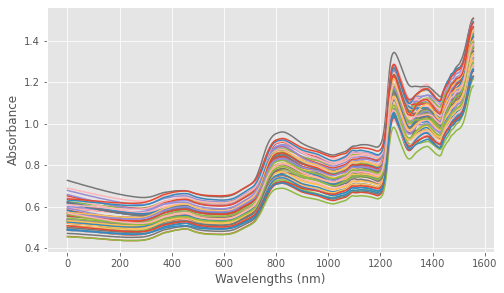

In [7]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df.iloc[:,1:-2].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

In [8]:
#df.iloc[:,1:-2] = snv(df.values[:,1:-2])
df.iloc[:,1:-2] = savgol_filter(df.values[:,1:-2], 15, polyorder=2, deriv=2)
#df.iloc[:,1:-2] = snv(df.values[:,1:-2])
df_pretreat = df.iloc[:, 1:-2]
df_pretreat['Umidade'] = df['Moisture Content (%)']
df_pretreat['Oleo'] = df['Fat Content (%)']
df_pretreat['class'] = df_pretreat['Oleo'].astype(int)

for index, row in df_pretreat.iterrows():
    if row['Oleo']< 36.3 :
        df_pretreat.loc[index, 'class'] = 35
#     if row['Oleo']> 38 and row['Oleo']< 38.25 :
#         df_pretreat.loc[index, 'class'] = 37
#     if row['class']== 41:
#         df_pretreat.loc[index, 'class'] = 40
#     if row['class']== 42:
#         df_pretreat.loc[index, 'class'] = 41
#     if row['class']== 43:
#         df_pretreat.loc[index, 'class'] = 42
    if row['class']== 45:
        df_pretreat.loc[index, 'class'] = 44

df_pretreat

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,Umidade,Oleo,class
0,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000007,2.703685e-06,...,-0.000467,-0.000467,-0.000467,-0.000467,-0.000467,-0.000467,-0.000467,8.17,39.11000,39
1,-0.000011,-0.000011,-0.000011,-0.000011,-0.000011,-0.000011,-0.000011,-0.000011,-0.000005,-1.779202e-06,...,-0.000456,-0.000456,-0.000456,-0.000456,-0.000456,-0.000456,-0.000456,7.52,39.14000,39
2,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000005,2.780284e-06,...,-0.000470,-0.000470,-0.000470,-0.000470,-0.000470,-0.000470,-0.000470,8.52,42.35439,42
3,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000004,-1.152893e-06,...,-0.000449,-0.000449,-0.000449,-0.000449,-0.000449,-0.000449,-0.000449,8.65,42.71632,42
4,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,0.000001,4.558436e-06,...,-0.000465,-0.000465,-0.000465,-0.000465,-0.000465,-0.000465,-0.000465,7.66,38.57000,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000004,5.214981e-06,...,-0.000423,-0.000423,-0.000423,-0.000423,-0.000423,-0.000423,-0.000423,9.29,36.49000,36
68,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018,-0.000029,-1.856938e-05,...,-0.000357,-0.000357,-0.000357,-0.000357,-0.000357,-0.000357,-0.000357,8.02,41.30000,41
69,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000017,-9.768584e-06,...,-0.000347,-0.000347,-0.000347,-0.000347,-0.000347,-0.000347,-0.000347,7.70,38.89000,38
70,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000003,2.859292e-06,...,-0.000366,-0.000366,-0.000366,-0.000366,-0.000366,-0.000366,-0.000366,7.77,39.37000,39


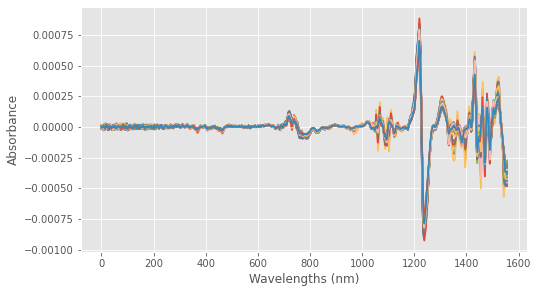

In [9]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df_pretreat.iloc[:,:-3].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

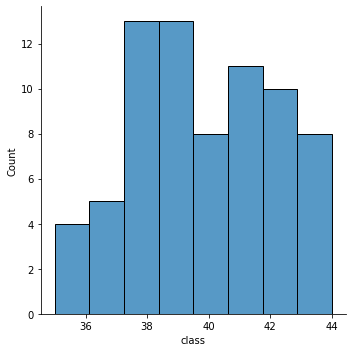

In [10]:
import seaborn as sns
sns.displot(df_pretreat['class'])

In [466]:
df_pretreat[df_pretreat['class']==8]

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,Umidade,Oleo,class


In [451]:
df_pretreat['class'].nunique()

10

In [352]:




pca = PCA(n_components=5)
T = pca.fit_transform(df_pretreat.iloc[:,:-3].values)
df_pca = pd.DataFrame(T)
df_pca.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'}, inplace=True)

print(pca.explained_variance_ratio_)


[0.52149265 0.19601489 0.15091996 0.06237402 0.02763389]


In [69]:
#df_pca['PC1'] = df_pca['PC1']*-1
df_pca['PC2'] = df_pca['PC2']*-1
df_pca['ID'] = df['sample Num']
df_pca

,PC1,PC2,PC3,PC4,PC5,ID
0,-0.005806,-0.001853,-0.002422,-0.000318,-0.000533,1
1,-0.005280,-0.001893,-0.002498,-0.000402,-0.000768,2
2,-0.006186,-0.001068,-0.002292,-0.000977,0.000524,3
3,-0.004698,-0.002666,-0.002731,-0.000445,-0.000769,4
4,-0.005910,-0.001206,-0.002279,0.000070,0.000081,5
...,...,...,...,...,...,...
67,-0.002943,-0.003044,-0.001475,-0.000229,-0.000552,68
68,0.006656,0.002368,0.001296,0.004447,-0.002182,69
69,0.005736,0.001557,0.001370,0.005109,-0.001442,70
70,-0.005306,-0.012580,0.001204,0.002264,0.000288,71


In [70]:
import plotly.express as px

fig = px.scatter(df_pca, x='PC1', y='PC2', render_mode='svg', hover_data=['ID'])

fig.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [1557] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [2] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [1557] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Outliers marked using Hotellings T2 method.'}, xlabel='PC1 (93.4% expl.var)', ylabel='PC2 (4.49% expl.var)'>)

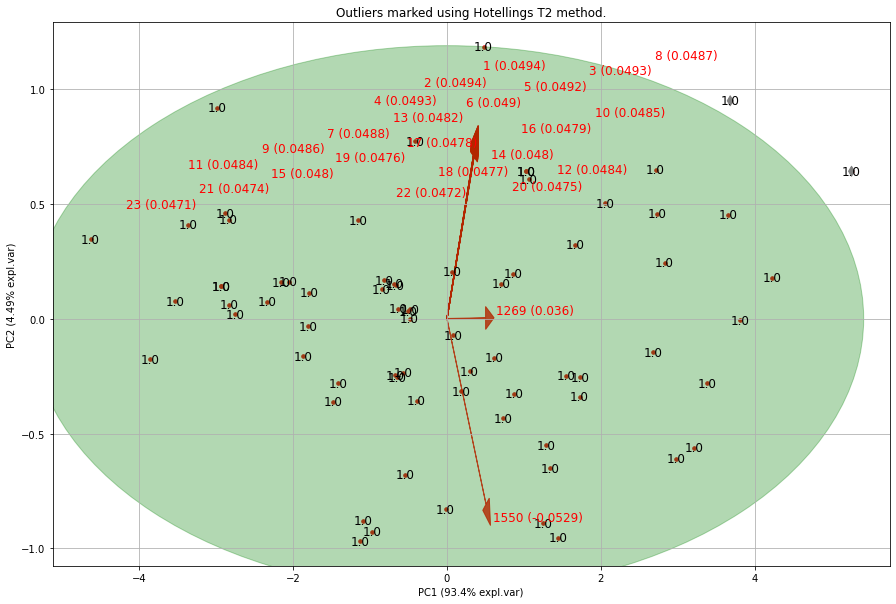

In [176]:
# import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from pca import pca

pca_model = pca(detect_outliers=['ht2', 'spe'],n_std=2.5 )

results = pca_model.fit_transform(X)
#PCA(n_components=5)
# Plot Hotellings T2
pca_model.biplot(SPE=True, hotellingt2=True, title='Outliers marked using Hotellings T2 method.', legend=False)

In [412]:
# df_pretreat = df.iloc[:, 1:-2]
# df_pretreat['Umidade'] = df['Moisture Content (%)']
# df_pretreat['Oleo'] = df['Fat Content (%)']

In [423]:
# ###Remove maybe 39 and 42
# df_pretreat.drop([39,42], inplace=True)

In [12]:
df_pretreat['class'] = 0
for index, row in df_pretreat.iterrows():
    if row['Umidade'] < 8:
        df_pretreat.loc[index, 'class'] = 0
    elif row['Umidade'] < 9:
        df_pretreat.loc[index, 'class'] = 1
    elif row['Umidade'] < 10:
        df_pretreat.loc[index, 'class'] = 2
    else:
        df_pretreat.loc[index, 'class'] = 3

In [383]:
# ##Derive 3 + SNV




y = df_pretreat[['Umidade','Oleo','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,stratify=y['class'])


# col = [0,1,2,3,4,5,7,8,9,10,12,13,14,16,17,19,21,27,28,30,34,37,38,39,40,41,42,44,46,47,49,50,51,52,53,55,56,59,60,61,64,65,66,67,68,69,70,71,72,75,76,79,81,84,85,86,94,95,99,105,106,107,109,110,115,116,118,119,120,121,127,128,129,132,133,136,137,140,142,143,146,147,148,150,151,153,158,159,160,163,164,165,166,167,168,169,175,180,181,182,188,189,191,192,195,196,199,200,205,208,209,212,214,215,216,219,223,225,227,228,229,232,233,237,238,239,243,246,247,248,249,252,255,258,260,262,269,270,271,273,275,279,280,281,283,284,285,286,287,290,292,293,296,297,298,299,300,301,303,304,305,306,307,308,310,311,312,313,314,315,317,319,320,322,328,331,335,337,338,339,340,341,343,349,351,352,355,357,367,370,371,373,375,379,381,384,385,388,389,390,391,392,393,394,395,396,397,401,402,403,405,406,409,415,419,420,422,423,424,425,426,428,429,430,431,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,461,462,463,464,465,469,470,471,472,474,475,476,477,478,479,482,483,484,485,486,487,488,491,492,493,495,497,498,499,500,501,502,505,508,509,510,512,514,515,519,525,527,528,532,533,535,536,542,544,545,550,552,553,554,559,560,562,563,567,569,573,576,577,578,580,583,584,585,586,587,588,590,594,598,599,601,602,603,604,605,606,609,610,611,615,619,622,624,627,628,629,630,631,632,635,637,638,639,641,645,646,647,651,652,653,655,657,658,659,660,662,663,664,665,668,670,671,673,675,676,678,679,680,683,685,686,687,690,691,692,694,698,699,707,708,709,710,716,719,721,724,728,731,732,738,747,748,749,750,753,754,756,761,763,764,766,767,769,774,775,779,780,781,783,785,786,787,792,794,798,801,802,803,805,809,810,811,815,816,818,822,824,825,827,828,829,830,832,833,834,837,838,839,840,841,842,843,844,845,850,852,854,856,858,859,860,865,866,867,869,870,871,872,874,875,882,884,887,888,889,890,891,892,893,894,897,898,899,901,902,907,909,911,915,916,917,918,921,922,924,925,927,929,931,932,933,934,935,936,937,938,943,944,948,950,954,956,959,961,962,964,968,969,972,975,978,982,983,984,986,990,991,995,997,998,1000,1001,1003,1005,1007,1009,1010,1016,1017,1018,1019,1020,1028,1033,1034,1041,1047,1052,1053,1062,1063,1064,1070,1071,1072,1073,1075,1076,1078,1079,1082,1083,1084,1087,1088,1089,1092,1096,1097,1100,1101,1103,1106,1107,1108,1109,1110,1112,1115,1116,1117,1121,1123,1124,1126,1127,1131,1132,1134,1136,1140,1143,1146,1153,1154,1157,1159,1163,1164,1165,1166,1167,1168,1172,1173,1174,1176,1182,1183,1184,1188,1191,1193,1194,1197,1198,1201,1204,1208,1209,1214,1215,1216,1217,1218,1221,1223,1224,1226,1227,1228,1229,1232,1236,1237,1238,1241,1243,1245,1246,1247,1249,1250,1251,1253,1262,1265,1273,1277,1280,1281,1282,1283,1284,1285,1287,1288,1289,1291,1292,1293,1295,1296,1300,1301,1305,1306,1308,1309,1310,1311,1312,1317,1319,1320,1324,1325,1326,1327,1329,1331,1332,1334,1335,1338,1339,1341,1343,1345,1346,1347,1349,1352,1353,1355,1356,1357,1360,1361,1366,1367,1368,1371,1373,1374,1375,1376,1377,1378,1383,1392,1394,1397,1402,1403,1405,1408,1409,1410,1411,1413,1414,1416,1420,1422,1423,1424,1425,1426,1428,1432,1433,1434,1437,1438,1441,1447,1450,1451,1452,1453,1456,1458,1461,1462,1464,1467,1468,1471,1472,1475,1477,1478,1485,1487,1488,1489,1490,1493,1495,1497,1501,1507,1509,1510,1515,1517,1519,1521,1522,1523,1526,1529,1530,1533,1536,1538,1539,1540,1547,1549,1553,1554,1555]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))
# col = [  1,   4,   5,   6,  12,  13,  14,  15,  16,  20,  23,  24,  28,
#         30,  31,  34,  37,  40,  46,  47,  50,  51,  58,  60,  61,  62,
#         63,  64,  66,  67,  71,  72,  75,  77,  78,  79,  80,  86,  91,
#         93,  94,  96,  97, 103, 104, 105, 106, 107, 113, 118, 120, 121,
#        126, 130, 132, 134, 135, 137, 139, 140, 141, 144, 152, 153, 155,
#        160, 161, 162, 163, 164, 167, 168, 169, 170, 172, 175, 177, 180,
#        181, 182, 183, 186, 194, 195, 197, 199, 200, 202, 211, 213, 215,
#        220, 222, 225, 226, 227, 230, 231, 235, 236, 237, 240, 242, 246,
#        249, 250, 254, 255, 258, 259, 260, 261, 264, 268, 270, 272, 276,
#        278, 283, 286, 287, 288, 289, 291, 293, 298, 300, 302, 309, 311,
#        312, 313, 315, 317, 319, 320, 322, 323, 324, 325, 326, 329, 331,
#        332, 334, 336, 337, 339, 344, 345, 346, 349, 351, 352, 353, 356,
#        357, 359, 363, 365, 368, 371, 373, 375, 376, 377, 378, 379, 381,
#        383, 384, 386, 387, 390, 393, 395, 396, 397, 400, 401, 403, 407,
#        409, 410, 411, 413, 415, 416, 417, 420, 421, 424, 425, 427, 428,
#        429, 430, 432, 434, 436, 437, 439, 440, 441, 445, 446, 450, 451,
#        452, 453, 454, 457, 458, 461, 462, 464, 466, 467, 468, 470, 471,
#        473, 474, 477, 479, 482, 486, 488, 490, 493, 496, 497, 500, 501,
#        503, 508, 511, 512, 515, 517, 518, 519, 521, 522, 523, 525, 526,
#        529, 531, 533, 535, 539, 542, 543, 544, 545, 546, 548, 549, 551,
#        552, 564, 565, 570, 571, 572, 574, 576, 579, 581, 583, 585, 590,
#        591, 592, 593, 594, 595, 602, 603, 604, 605, 606, 607, 610, 611,
#        612, 614, 615, 617, 618, 621, 622, 623, 626, 628, 630, 631, 633,
#        634, 638, 639, 640, 642, 643, 646, 647, 648, 649, 650, 658, 660,
#        661, 662, 668, 669, 679, 683, 685, 686, 688, 690, 691, 692, 698,
#        699, 703, 705, 706, 708, 709, 710, 712, 717, 718, 721, 723, 725,
#        726, 727, 730, 732, 735, 737, 738, 746, 750, 751, 752, 754, 756,
#        760, 762, 763, 765, 766, 769, 770, 771, 773, 774, 776]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [0,   1,   2,   6,   8,  11,  12,  15,  18,  20,  22,  24,  25,
#         27,  29,  30,  32,  36,  38,  39,  40,  42,  43,  47,  48,  49,
#         58,  59,  62,  65,  67,  68,  72,  74,  75,  77,  78,  79,  80,
#         82,  85,  86,  88,  96, 101, 108, 110, 112, 115, 118, 120, 122,
#        123, 124, 125, 126, 127, 129, 131, 136, 137, 138, 139, 141, 142,
#        143, 144, 145, 146, 147, 152, 157, 160, 166, 168, 170, 173, 176,
#        177, 180, 184, 188, 189, 190, 194, 196, 202, 204, 209, 211, 213,
#        214, 215, 216, 219, 222, 223, 225, 227, 228, 232, 233, 235, 236,
#        240, 241, 247, 248, 249, 251, 257, 263, 268, 271, 273, 276, 277,
#        280, 281, 288, 291, 292, 294, 296, 297, 298, 299, 304, 305, 306,
#        307, 308, 310, 311, 313, 315, 316, 318, 319, 322, 323, 325, 328,
#        329, 332, 335, 341, 346, 347, 348, 353, 360, 364, 365, 366, 367,
#        373, 375, 377, 378, 379, 380, 381, 382, 383, 385, 387, 388, 391,
#        392, 395, 396, 397, 403, 406, 407, 408, 409, 410, 414]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# # col = [1,   4,   6,   9,  12,  17,  18,  19,  22,  23,  24,  26,  33,
# #         34,  35,  41,  48,  52,  53,  58,  60,  61,  63,  66,  68,  70,
# #         72,  75,  78,  79,  82,  84,  86,  87,  88,  90,  91,  92,  95,
# #         99, 102, 105, 107, 111, 115, 116, 125, 126, 127, 128, 129, 130,
# #        132, 133, 135, 136, 140, 145, 147, 148, 149, 150, 151, 152, 154,
# #        157, 160, 161, 163, 165, 171, 172, 175, 178, 182, 184, 185, 187,
# #        189, 190, 193, 195, 196, 200, 201, 206, 208, 213, 216, 224, 226,
# #        227, 232]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  1,   8,   9,  11,  13,  25,  28,  29,  32,  41,  43,  47,  51,
# #         52,  53,  54,  55,  56,  57,  59,  65,  69,  72,  76,  84,  88,
# #         89,  93,  95,  97,  99, 101, 102, 104, 114, 115, 117, 123, 125,
# #        126, 128, 130, 132, 140, 144, 146, 147, 148, 149]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  0,  6,  9, 10, 13, 14, 15, 18, 20, 21, 22, 23, 25, 28, 29, 32, 35,
# #        40, 42, 44, 45, 48, 53, 54, 67, 68, 71, 78, 83, 86, 89, 93]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  4,  6,  8, 15, 25, 41, 43, 44, 49, 51, 54, 58, 61, 64, 74, 78]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  8, 23, 27, 48, 53, 54, 58, 63]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))


# # X_train_snv = msc(X_train)
# # X_#test_snv = msc(X_test)

y_train_oleo = y_train['Oleo']


y_test_oleo = y_test['Oleo']

# #X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
# #X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# # X_train_snv = msc(X_train)
# # X_test_snv = msc(X_test)

# # mean centre correction
# #X_mc = mc(X1)

# ##Standard Normal Variate

# # Xsnv = snv(X_train)

In [11]:
##Derive 3 + SNV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Oleo','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,stratify=y['class'])


col = [1,3,4,5,6,7,8,11,13,14,18,21,22,23,24,30,31,32,33,36,38,41,42,43,45,47,51,60,61,65,66,67,70,73,75,78,79,81,82,85,86,87,89,92,94,97,99,103,105,106,107,109,110,111,113,115,118,119,121,127,128,129,130,132,134,137,140,147,148,152,158,160,163,164,165,166,169,172,179,181,188,189,190,192,196,197,198,199,201,202,203,206,208,209,210,212,213,214,215,217,218,219,220,222,225,229,230,231,233,237,239,240,242,243,244,246,248,249,251,252,257,259,260,261,263,264,267,268,272,275,276,278,279,280,284,285,286,287,288,290,293,295,296,297,298,299,300,302,303,304,307,308,310,311,312,314,315,319,321,322,327,328,329,330,334,335,341,342,344,350,355,356,365,368,369,370,382,383,384,386,388,389,390,391,392,393,394,397,398,403,404,406,408,409,411,412,413,414,415,419,420,421,422,423,424,427,428,429,431,433,435,436,438,440,442,443,444,447,448,449,450,454,455,456,458,460,463,468,469,471,473,475,476,477,478,479,480,484,485,486,490,493,494,496,498,500,501,504,505,506,508,509,510,511,512,514,520,521,525,528,531,532,533,534,535,538,541,543,546,547,549,550,556,558,559,560,566,567,568,569,571,575,576,577,578,579,582,584,585,586,588,589,592,595,596,599,602,603,604,605,606,608,609,610,611,618,623,626,628,629,632,635,636,641,643,645,646,650,651,652,659,660,663,664,668,670,673,674,675,676,681,682,683,685,686,688,689,691,695,696,698,699,702,703,706,707,710,711,713,715,717,719,722,726,727,728,729,730,731,732,733,734,735,736,737,739,741,747,748,749,750,753,756,762,763,767,772,775,782,790,791,793,797,799,800,802,804,805,806,807,810,811,813,815,816,817,818,824,827,828,829,830,831,834,835,836,837,838,839,840,841,842,843,844,848,849,850,852,853,854,856,857,859,860,866,869,871,873,876,877,878,880,882,884,885,888,889,890,891,895,897,898,899,902,903,905,906,907,909,911,912,916,917,918,919,921,922,923,924,926,929,930,931,933,936,939,940,943,948,949,957,959,960,961,965,967,968,969,970,971,972,973,974,977,980,981,984,989,991,992,993,997,998,999,1001,1008,1009,1011,1012,1014,1018,1019,1020,1022,1023,1025,1026,1031,1033,1035,1042,1047,1049,1051,1052,1056,1059,1062,1064,1066,1069,1071,1072,1074,1076,1077,1080,1082,1084,1085,1087,1089,1090,1091,1097,1098,1105,1106,1107,1110,1112,1113,1115,1117,1121,1123,1124,1125,1127,1128,1129,1130,1132,1133,1136,1139,1140,1150,1151,1153,1154,1155,1156,1161,1168,1170,1173,1177,1179,1182,1183,1185,1187,1190,1193,1197,1202,1203,1205,1206,1209,1210,1212,1213,1217,1218,1221,1224,1226,1228,1232,1235,1236,1237,1239,1240,1244,1248,1249,1262,1264,1266,1268,1274,1275,1276,1277,1282,1288,1289,1290,1292,1293,1303,1310,1311,1312,1314,1320,1321,1322,1323,1326,1327,1334,1335,1343,1344,1346,1347,1348,1349,1351,1353,1354,1355,1358,1361,1362,1368,1371,1372,1373,1376,1377,1380,1384,1385,1387,1388,1391,1392,1393,1397,1400,1401,1403,1406,1407,1410,1417,1418,1419,1420,1421,1423,1424,1425,1427,1429,1434,1437,1438,1439,1442,1448,1449,1451,1452,1453,1457,1463,1464,1466,1470,1472,1476,1479,1480,1483,1486,1488,1490,1493,1494,1495,1498,1505,1508,1509,1511,1512,1513,1514,1518,1519,1521,1523,1525,1526,1528,1531,1533,1534,1536,1537,1540,1541,1542,1548,1549,1553,1554]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))
col = [ 2,   4,   5,   6,   7,   8,   9,  12,  13,  16,  18,  19,  20,
        22,  27,  28,  30,  31,  33,  34,  35,  36,  38,  39,  42,  45,
        46,  47,  49,  50,  51,  52,  54,  58,  59,  62,  66,  67,  71,
        73,  74,  76,  77,  80,  81,  88,  90,  91,  94, 101, 102, 103,
       105, 106, 108, 110, 111, 112, 128, 129, 132, 134, 137, 138, 139,
       140, 141, 144, 147, 149, 150, 151, 152, 155, 156, 158, 159, 162,
       163, 167, 168, 169, 171, 173, 175, 181, 183, 185, 186, 189, 193,
       194, 195, 196, 197, 198, 199, 206, 212, 213, 214, 215, 216, 217,
       222, 223, 224, 226, 228, 231, 232, 234, 236, 237, 239, 242, 246,
       247, 248, 251, 252, 253, 254, 255, 256, 257, 266, 267, 271, 276,
       280, 281, 284, 285, 286, 288, 289, 291, 292, 297, 299, 303, 304,
       307, 312, 313, 316, 319, 321, 322, 323, 324, 328, 333, 334, 335,
       336, 338, 341, 342, 344, 346, 349, 350, 351, 355, 357, 358, 361,
       363, 365, 366, 368, 369, 370, 371, 373, 374, 376, 377, 380, 384,
       389, 395, 396, 400, 404, 405, 411, 412, 413, 414, 416, 417, 418,
       419, 420, 421, 423, 427, 431, 433, 434, 436, 440, 443, 444, 445,
       446, 448, 451, 453, 455, 457, 460, 461, 466, 467, 472, 473, 474,
       475, 477, 479, 480, 481, 482, 483, 484, 485, 487, 489, 491, 493,
       494, 495, 496, 497, 498, 499, 504, 513, 517, 520, 522, 523, 524,
       528, 529, 530, 531, 536, 537, 539, 542, 543, 544, 546, 547, 550,
       552, 553, 554, 555, 558, 559, 566, 567, 571, 574, 578, 579, 583,
       584, 586, 587, 588, 589, 594, 595, 596, 597, 600, 602, 603, 604,
       606, 607, 609, 611, 614, 621, 622, 623, 624, 626, 632, 637, 638,
       645, 646, 647, 648, 649, 650, 662, 664, 665, 668, 670, 674, 676,
       677, 680, 681, 682, 683, 684, 685, 686, 690, 691, 693, 694, 698,
       699, 703, 704, 706, 711, 715, 721, 722, 723, 725, 729, 730, 731,
       735, 737, 739, 744, 747, 748, 749, 750, 751, 752, 763, 764, 766,
       767, 768, 769, 771, 773, 774, 777, 779, 780, 781, 783, 784, 785,
       786, 790, 794, 796, 797, 800, 801, 802, 803, 804, 810, 812, 814,
       815, 819, 823, 827, 828, 831]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [0,   1,   6,   7,  11,  13,  14,  15,  18,  21,  24,  26,  29,
        30,  31,  34,  37,  38,  41,  42,  45,  46,  47,  52,  59,  62,
        65,  66,  71,  72,  75,  76,  78,  79,  81,  82,  83,  84,  87,
        89,  90,  92,  93,  95, 102, 106, 107, 110, 113, 118, 121, 124,
       128, 131, 134, 141, 143, 144, 147, 148, 150, 151, 152, 153, 154,
       155, 156, 158, 159, 166, 167, 168, 169, 173, 174, 175, 176, 182,
       184, 188, 189, 190, 195, 196, 201, 205, 208, 210, 217, 219, 221,
       223, 224, 225, 226, 228, 232, 233, 236, 238, 243, 244, 245, 246,
       248, 250, 251, 252, 255, 256, 259, 262, 263, 264, 269, 270, 271,
       273, 277, 279, 292, 293, 294, 295, 296, 298, 300, 301, 302, 303,
       307, 308, 311, 316, 322, 325, 326, 327, 328, 342, 343, 346, 350,
       352, 358, 362, 366, 367, 368, 370, 371, 373, 374, 377, 381, 382,
       387, 389, 394, 395, 397, 398, 405, 406, 407, 409, 410, 411, 415,
       418, 420, 422, 423, 425, 426, 427, 429, 431, 437, 438, 439, 441,
       442, 443, 449]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))



col = [0,   4,   5,   8,  10,  11,  18,  19,  21,  26,  30,  31,  32,
        33,  35,  41,  48,  49,  50,  51,  57,  58,  60,  62,  63,  68,
        69,  72,  79,  81,  86,  87,  90,  91,  94,  96,  98,  99, 102,
       110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 125,
       128, 129, 131, 132, 135, 136, 140, 141, 142, 145, 146, 156, 162,
       163, 169, 177, 178, 182, 183, 190, 193, 194, 196, 198, 200, 202,
       203, 205, 206, 213, 216, 217, 221, 222, 227, 228, 234, 238, 240,
       241, 242, 246, 249, 250, 257, 260, 261, 262]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

#A peut etre amelioer
col = [   6,   9,  10,  16,  18,  19,  24,  27,  28,  29,  33,  35,  38,
        42,  44,  49,  50,  52,  56,  57,  59,  61,  62,  64,  69,  72,
        74,  77,  78,  79,  81,  82,  88,  92,  94,  95,  99, 101, 102,
       105, 109, 111, 112, 122, 125, 127, 128, 131, 132, 134, 135, 137,
       151, 155, 156, 157, 161, 162, 164, 165]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

# ###1

# # col = [  0,  6,  9, 10, 13, 14, 15, 18, 20, 21, 22, 23, 25, 28, 29, 32, 35,
# #        40, 42, 44, 45, 48, 53, 54, 67, 68, 71, 78, 83, 86, 89, 93]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  4,  6,  8, 15, 25, 41, 43, 44, 49, 51, 54, 58, 61, 64, 74, 78]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  8, 23, 27, 48, 53, 54, 58, 63]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))


# 1#######################05-09
# col = [  1, 11, 12, 15, 22, 30, 31, 36, 37, 43, 49, 50, 51, 52, 57, 59, 61,
#        65, 68, 70, 72, 73, 77, 78, 84, 85, 86, 88, 92, 96, 99]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

#####################

# X_train_snv = msc(X_train)
# X_#test_snv = msc(X_test)

y_train_oleo = y_train['Oleo']


y_test_oleo = y_test['Oleo']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [487]:
# ##Derive 3 + SNV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Oleo','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y['class'])


col = [2,3,5,8,11,13,17,19,20,21,26,27,28,29,30,32,33,35,36,37,38,39,40,41,43,44,45,46,47,51,52,53,54,55,56,57,63,66,67,70,71,72,76,77,78,79,80,81,83,86,87,88,89,90,91,92,94,102,103,104,106,107,109,110,111,115,122,126,128,130,131,132,133,134,139,140,142,146,149,150,152,154,155,156,160,161,162,163,164,169,175,176,177,179,183,185,186,187,188,190,192,193,194,195,197,198,200,201,211,212,213,215,216,218,222,223,226,227,230,231,232,234,235,236,238,239,240,243,244,248,249,250,251,255,256,258,260,263,264,265,267,269,270,272,273,274,276,278,279,280,281,288,290,291,292,293,294,298,299,301,302,304,307,308,310,311,315,316,318,319,320,321,323,325,326,327,329,330,332,336,338,342,343,344,345,346,347,348,352,353,355,362,364,366,368,370,372,373,374,378,381,384,386,387,388,391,392,393,400,401,405,406,407,410,411,412,413,417,418,419,421,424,426,428,429,430,431,437,441,445,446,449,455,457,459,461,463,465,467,469,470,472,474,476,478,479,482,483,484,485,487,488,491,495,496,498,501,502,503,504,505,506,508,510,511,513,514,515,516,517,521,522,524,527,528,529,530,531,538,540,544,546,549,551,553,556,557,560,563,565,566,567,568,569,570,572,573,576,578,579,580,581,582,585,586,592,598,599,601,603,605,609,610,612,613,614,617,619,622,625,626,628,629,631,633,636,637,638,641,643,644,646,647,649,650,652,653,654,663,664,665,666,667,669,672,673,675,678,680,682,689,691,695,697,699,700,701,706,712,714,715,717,722,723,724,725,726,727,728,729,730,732,733,735,736,737,739,740,741,743,745,746,748,749,751,752,753,754,755,756,757,758,761,762,765,767,768,770,773,775,780,782,791,796,798,799,807,811,813,814,816,817,820,822,823,826,828,830,831,832,835,836,840,841,846,847,853,855,857,858,860,862,864,865,869,872,879,880,881,883,885,886,891,892,893,894,896,898,901,905,906,907,910,913,916,917,918,919,922,925,927,928,929,931,932,934,937,941,945,946,948,950,951,953,954,955,956,957,958,961,963,965,966,967,969,972,977,978,981,982,983,984,986,993,994,996,998,1000,1001,1002,1013,1015,1018,1019,1021,1022,1023,1026,1027,1028,1030,1031,1032,1033,1035,1037,1038,1040,1041,1042,1043,1044,1045,1046,1047,1048,1050,1051,1052,1053,1055,1056,1057,1059,1060,1064,1065,1067,1068,1069,1071,1072,1073,1076,1079,1081,1082,1084,1086,1088,1089,1090,1091,1095,1096,1106,1107,1109,1115,1116,1119,1121,1123,1126,1127,1130,1132,1135,1136,1137,1138,1139,1140,1148,1149,1150,1154,1156,1158,1160,1161,1162,1163,1166,1168,1171,1173,1174,1175,1179,1180,1181,1182,1184,1185,1189,1190,1191,1193,1195,1197,1199,1202,1204,1206,1207,1208,1209,1210,1212,1216,1217,1218,1219,1222,1223,1224,1225,1226,1227,1228,1235,1236,1237,1241,1242,1243,1244,1245,1248,1249,1255,1258,1259,1260,1261,1265,1266,1267,1268,1269,1271,1272,1273,1275,1279,1280,1282,1283,1284,1285,1286,1292,1294,1295,1297,1298,1303,1308,1310,1311,1314,1318,1319,1321,1324,1325,1327,1328,1332,1333,1334,1336,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1352,1353,1354,1358,1360,1363,1372,1373,1375,1377,1378,1381,1382,1383,1387,1388,1390,1391,1392,1395,1396,1397,1400,1404,1407,1409,1410,1412,1413,1414,1418,1419,1420,1421,1424,1425,1427,1431,1433,1434,1435,1436,1437,1440,1444,1445,1449,1450,1451,1453,1454,1458,1459,1461,1464,1466,1469,1473,1475,1476,1478,1481,1482,1483,1484,1485,1486,1488,1491,1494,1495,1496,1499,1500,1501,1502,1503,1506,1507,1510,1511,1512,1516,1518,1521,1522,1524,1527,1529,1530,1531,1532,1534,1537,1538,1539,1540,1541,1542,1545,1546,1549,1551]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))
# col = [  1,   4,   5,   6,  12,  13,  14,  15,  16,  20,  23,  24,  28,
#         30,  31,  34,  37,  40,  46,  47,  50,  51,  58,  60,  61,  62,
#         63,  64,  66,  67,  71,  72,  75,  77,  78,  79,  80,  86,  91,
#         93,  94,  96,  97, 103, 104, 105, 106, 107, 113, 118, 120, 121,
#        126, 130, 132, 134, 135, 137, 139, 140, 141, 144, 152, 153, 155,
#        160, 161, 162, 163, 164, 167, 168, 169, 170, 172, 175, 177, 180,
#        181, 182, 183, 186, 194, 195, 197, 199, 200, 202, 211, 213, 215,
#        220, 222, 225, 226, 227, 230, 231, 235, 236, 237, 240, 242, 246,
#        249, 250, 254, 255, 258, 259, 260, 261, 264, 268, 270, 272, 276,
#        278, 283, 286, 287, 288, 289, 291, 293, 298, 300, 302, 309, 311,
#        312, 313, 315, 317, 319, 320, 322, 323, 324, 325, 326, 329, 331,
#        332, 334, 336, 337, 339, 344, 345, 346, 349, 351, 352, 353, 356,
#        357, 359, 363, 365, 368, 371, 373, 375, 376, 377, 378, 379, 381,
#        383, 384, 386, 387, 390, 393, 395, 396, 397, 400, 401, 403, 407,
#        409, 410, 411, 413, 415, 416, 417, 420, 421, 424, 425, 427, 428,
#        429, 430, 432, 434, 436, 437, 439, 440, 441, 445, 446, 450, 451,
#        452, 453, 454, 457, 458, 461, 462, 464, 466, 467, 468, 470, 471,
#        473, 474, 477, 479, 482, 486, 488, 490, 493, 496, 497, 500, 501,
#        503, 508, 511, 512, 515, 517, 518, 519, 521, 522, 523, 525, 526,
#        529, 531, 533, 535, 539, 542, 543, 544, 545, 546, 548, 549, 551,
#        552, 564, 565, 570, 571, 572, 574, 576, 579, 581, 583, 585, 590,
#        591, 592, 593, 594, 595, 602, 603, 604, 605, 606, 607, 610, 611,
#        612, 614, 615, 617, 618, 621, 622, 623, 626, 628, 630, 631, 633,
#        634, 638, 639, 640, 642, 643, 646, 647, 648, 649, 650, 658, 660,
#        661, 662, 668, 669, 679, 683, 685, 686, 688, 690, 691, 692, 698,
#        699, 703, 705, 706, 708, 709, 710, 712, 717, 718, 721, 723, 725,
#        726, 727, 730, 732, 735, 737, 738, 746, 750, 751, 752, 754, 756,
#        760, 762, 763, 765, 766, 769, 770, 771, 773, 774, 776]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [0,   1,   2,   6,   8,  11,  12,  15,  18,  20,  22,  24,  25,
#         27,  29,  30,  32,  36,  38,  39,  40,  42,  43,  47,  48,  49,
#         58,  59,  62,  65,  67,  68,  72,  74,  75,  77,  78,  79,  80,
#         82,  85,  86,  88,  96, 101, 108, 110, 112, 115, 118, 120, 122,
#        123, 124, 125, 126, 127, 129, 131, 136, 137, 138, 139, 141, 142,
#        143, 144, 145, 146, 147, 152, 157, 160, 166, 168, 170, 173, 176,
#        177, 180, 184, 188, 189, 190, 194, 196, 202, 204, 209, 211, 213,
#        214, 215, 216, 219, 222, 223, 225, 227, 228, 232, 233, 235, 236,
#        240, 241, 247, 248, 249, 251, 257, 263, 268, 271, 273, 276, 277,
#        280, 281, 288, 291, 292, 294, 296, 297, 298, 299, 304, 305, 306,
#        307, 308, 310, 311, 313, 315, 316, 318, 319, 322, 323, 325, 328,
#        329, 332, 335, 341, 346, 347, 348, 353, 360, 364, 365, 366, 367,
#        373, 375, 377, 378, 379, 380, 381, 382, 383, 385, 387, 388, 391,
#        392, 395, 396, 397, 403, 406, 407, 408, 409, 410, 414]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# # col = [1,   4,   6,   9,  12,  17,  18,  19,  22,  23,  24,  26,  33,
# #         34,  35,  41,  48,  52,  53,  58,  60,  61,  63,  66,  68,  70,
# #         72,  75,  78,  79,  82,  84,  86,  87,  88,  90,  91,  92,  95,
# #         99, 102, 105, 107, 111, 115, 116, 125, 126, 127, 128, 129, 130,
# #        132, 133, 135, 136, 140, 145, 147, 148, 149, 150, 151, 152, 154,
# #        157, 160, 161, 163, 165, 171, 172, 175, 178, 182, 184, 185, 187,
# #        189, 190, 193, 195, 196, 200, 201, 206, 208, 213, 216, 224, 226,
# #        227, 232]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  1,   8,   9,  11,  13,  25,  28,  29,  32,  41,  43,  47,  51,
# #         52,  53,  54,  55,  56,  57,  59,  65,  69,  72,  76,  84,  88,
# #         89,  93,  95,  97,  99, 101, 102, 104, 114, 115, 117, 123, 125,
# #        126, 128, 130, 132, 140, 144, 146, 147, 148, 149]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  0,  6,  9, 10, 13, 14, 15, 18, 20, 21, 22, 23, 25, 28, 29, 32, 35,
# #        40, 42, 44, 45, 48, 53, 54, 67, 68, 71, 78, 83, 86, 89, 93]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  4,  6,  8, 15, 25, 41, 43, 44, 49, 51, 54, 58, 61, 64, 74, 78]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [  8, 23, 27, 48, 53, 54, 58, 63]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))


# # X_train_snv = msc(X_train)
# # X_#test_snv = msc(X_test)

y_train_oleo = y_train['Oleo']


y_test_oleo = y_test['Oleo']

# #X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
# #X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# # X_train_snv = msc(X_train)
# # X_test_snv = msc(X_test)

# # mean centre correction
# #X_mc = mc(X1)

# ##Standard Normal Variate

# # Xsnv = snv(X_train)

In [488]:
y_train

,Umidade,Oleo,class
39,9.74,43.07863,43
33,8.20,41.18000,41
20,7.89,39.84799,39
10,6.74,38.37085,38
55,8.18,39.32000,39
25,9.30,39.47000,39
9,8.29,38.72549,38
27,7.74,38.39479,38
36,10.30,42.58640,42
5,8.18,40.30501,40


In [489]:
y_test

,Umidade,Oleo,class
50,9.31,43.66000,43
66,9.56,36.69000,36
24,10.26,38.24000,38
60,7.42,39.57883,39
18,9.52,38.95028,38
68,8.02,41.30000,41
6,7.86,38.33000,38
23,9.29,39.91180,39
54,8.43,41.86681,41
57,8.21,40.63000,40


In [484]:

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X_train.shape[1] # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=100, verbose=2)
optimizer.reset()

2023-05-09 22:29:49,703 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=0.305
2023-05-09 22:43:56,611 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.3053267636298147, best pos: [1 1 0 ... 1 1 1]


best_cost=0.181

best_cost=0.107

best_cost=0.0982

In [485]:
np.where(pos == 0)[0]

array([   2,    3,    5,    8,   11,   13,   17,   19,   20,   21,   26,
         27,   28,   29,   30,   32,   33,   35,   36,   37,   38,   39,
         40,   41,   43,   44,   45,   46,   47,   51,   52,   53,   54,
         55,   56,   57,   63,   66,   67,   70,   71,   72,   76,   77,
         78,   79,   80,   81,   83,   86,   87,   88,   89,   90,   91,
         92,   94,  102,  103,  104,  106,  107,  109,  110,  111,  115,
        122,  126,  128,  130,  131,  132,  133,  134,  139,  140,  142,
        146,  149,  150,  152,  154,  155,  156,  160,  161,  162,  163,
        164,  169,  175,  176,  177,  179,  183,  185,  186,  187,  188,
        190,  192,  193,  194,  195,  197,  198,  200,  201,  211,  212,
        213,  215,  216,  218,  222,  223,  226,  227,  230,  231,  232,
        234,  235,  236,  238,  239,  240,  243,  244,  248,  249,  250,
        251,  255,  256,  258,  260,  263,  264,  265,  267,  269,  270,
        272,  273,  274,  276,  278,  279,  280,  2

In [486]:
with open("Col_to_delete_2023-04-30_Cacao_FAT_X_train_test_SVR_3.txt", "w") as txt_file:
    for line in np.where(pos == 0)[0]:
        txt_file.write(str(line)+',')

In [207]:
len(np.where(pos == 0)[0])

752

In [86]:
# from sklearn.pipeline import make_pipeline
# from sklearn.ensemble import RandomForestRegressor

# regr = make_pipeline(StandardScaler(),  SVR())

# X1 = X_train[:,pos==1] 

# X2 = X_test[:,pos==1] 

# X_ = X[:,pos==1] 

# regr.fit(X1, y_train_oleo)

# y_pred = regr.predict(X2)
# y_cv = regr.predict(X1)
# y_pred_tot = regr.predict(X_)


# score = r2_score(y_train_oleo, y_cv)
# score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
# score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)


# score_tot = r2_score(y['Oleo'], y_pred_tot)
# score_rmse_tot = mean_squared_error(y['Oleo'], y_pred_tot,squared=False)

# print('N Wave: ', X1.shape)
# print('R2CV: ', score)
# print('RMSECV: ', score_train)
# print('RMSE test: ', score_test)


# print('Pour comparaison')
# print('R2: ', score_tot)
# print('RMSE: ', score_rmse_tot)


In [12]:
ls_score_pls = []
n_opt = 8
for i in range(3,8):
    pls_simple = PLSRegression(n_components=i)
    cv = LeaveOneOut()
    #cv = 10

    X1 = X_train 
    #X1 = X_train[:,pos==1] 

    X2 = X_test
    #X2 = X_test[:,pos==1] 


    # Fit
    pls_simple.fit(X1, y_train_oleo)


    # Cross-validation
    y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
    y_pred = pls_simple.predict(X2)
    score = r2_score(y_train_oleo, y_cv)
    if ls_score_pls:
        if score< ls_score_pls[-1] and i>4:
            n_opt =  i-1
            break

    ls_score_pls.append(score)

pls_simple = PLSRegression(n_components=n_opt)
cv = LeaveOneOut()
# cv = 10

X1 = X_train 
#X1 = X_train[:,pos==1] 

X2 = X_test
#X2 = X_test[:,pos==1] 


# Fit
pls_simple.fit(X1, y_train_oleo)


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)
y_pred_tot = pls_simple.predict(X)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

score_tot = r2_score(y['Oleo'], y_pred_tot)
score_rmse_tot = mean_squared_error(y['Oleo'], y_pred_tot,squared=False)

print('N comp: ', n_opt)
print('N Wave: ', X_train.shape)
print('R2CV: ', score)
print('RMSECV: ', score_train)
print('RMSE test: ', score_test)


print('Pour comparaison')
print('R2: ', score_tot)
print('RMSE: ', score_rmse_tot)

N comp:  8
N Wave:  (61, 106)
R2CV:  0.9347812779145526
RMSECV:  0.5588174020339821
RMSE test:  1.567993871893588
Pour comparaison
R2:  0.9066753287000472
RMSE:  0.6532620204360127



N comp:  5
N Wave:  (61, 778)
R2CV:  0.7343664450386924
RMSECV:  1.1277822285190617
RMSE test:  1.1352061151005874
Pour comparaison
R2:  0.9217652761625856
RMSE:  0.5981208643204651

N comp:  5
N Wave:  (61, 402)
R2CV:  0.8120364465780741
RMSECV:  0.9486818741117063
RMSE test:  1.3181243744185414
Pour comparaison
R2:  0.9133632892576252
RMSE:  0.6294194411362429

N comp:  5
N Wave:  (61, 229)
R2CV:  0.8751485498154934
RMSECV:  0.773179935149487
RMSE test:  1.531180968252294
Pour comparaison
R2:  0.8970381761636714
RMSE:  0.6861629887517131



N comp:  8
N Wave:  (61, 416)
R2CV:  0.8518212667756905
RMSECV:  0.8423192352057604
RMSE test:  1.1411903355663389
Pour comparaison
R2:  0.9474139609619948
RMSE:  0.4903705782209487

N comp:  8
N Wave:  (61, 236)
R2CV:  0.8971020846605855
RMSECV:  0.701919112010572
RMSE test:  1.091971121779484
Pour comparaison
R2:  0.9514880286221825
RMSE:  0.47099211545560593

N comp:  5
N Wave:  (61, 834)
R2CV:  0.7415324738931992
RMSECV:  1.1124660663472692
RMSE test:  1.1248377442129465
Pour comparaison
R2:  0.918464528515502
RMSE:  0.6106079700959187

N comp:  5
N Wave:  (61, 266)
R2CV:  0.8919550458730521
RMSECV:  0.7192601913740643
RMSE test:  1.340147149289383
Pour comparaison
R2:  0.9218204459423571
RMSE:  0.5979099348620707

N comp:  8
N Wave:  (61, 1557)
R2CV:  0.5939325994237918
RMSECV:  1.3943854493739196
RMSE test:  0.9555725944907429
Pour comparaison
R2:  0.9601450346801992
RMSE:  0.4269041661179395

N comp:  8
N Wave:  (61, 834)
R2CV:  0.7636180340543433
RMSECV:  1.0638758478878196
RMSE test:  1.1163376357727033
Pour comparaison
R2:  0.9481809490938835
RMSE:  0.4867813182527165


N comp:  8
N Wave:  (61, 451)
R2CV:  0.871522426990227
RMSECV:  0.7843274983059583
RMSE test:  1.219853579808185
Pour comparaison
R2:  0.9425251429922483
RMSE:  0.5126584557769873

N comp:  8
N Wave:  (61, 266)
R2CV:  0.9065056539276471
RMSECV:  0.6690775434381815
RMSE test:  1.3334568143371728
Pour comparaison
R2:  0.9311674591083842
RMSE:  0.5610299884582348

N comp:  8
N Wave:  (61, 166)
R2CV:  0.9286408034597077
RMSECV:  0.5845326242688962
RMSE test:  1.5192462430086022
Pour comparaison
R2:  0.9131072934333112
RMSE:  0.6303486655737617

N comp:  8
N Wave:  (61, 106)
R2CV:  0.9347812779145526
RMSECV:  0.5588174020339821
RMSE test:  1.567993871893588
Pour comparaison
R2:  0.9066753287000472
RMSE:  0.6532620204360127

N comp:  8
N Wave:  (61, 75)
R2CV:  0.9383467848889131
RMSECV:  0.5433274463853454
RMSE test:  1.7026678886032511
Pour comparaison
R2:  0.8895367648789453
RMSE:  0.710719210413216

In [63]:
import plotly.express as px

df_pred = pd.DataFrame()
df_pred['y'] = y['Umidade'].values
df_pred['y_pred'] = y_pred
fig = px.scatter(df_pred, x="y", y="y_pred", trendline="ols", title="Prediction performance for moisture content ",
                 labels={
                     "y": "Moisture content measured (%)",
                     "y_pred": "Moisture content predicted (%)",

                 },width=600, height=400)
fig.show()

In [614]:
#Wavelength to keep
wl_list = np.arange(0, 1557, 1)
col = [ 4,6,10,12,19,23,30,32,33,35,36,37,41,42,44,49,52,54,55,63,65,67,70,71,72,74,76,77,80,81,82,85,87,89,93,98,101,108,111,112,115,116,118,120,121,122,123,124,129,131,134,139,147,148,149,150,151,153,155,157,158,159,160,161,163,165,166,168,170,173,176,177,178,179,181,182,187,188,190,191,192,193,196,197,199,203,204,205,207,209,212,222,223,228,229,231,233,235,236,237,239,246,248,249,251,259,263,264,268,270,271,274,279,282,284,287,292,293,295,298,300,301,302,305,310,313,318,322,326,327,331,334,338,339,341,343,348,350,353,354,357,358,359,360,362,365,367,368,371,373,374,375,376,383,384,386,388,389,391,392,393,394,395,396,401,402,403,405,406,410,411,412,414,415,416,417,418,419,420,421,422,424,425,426,428,429,431,432,433,434,435,437,438,439,443,444,445,447,453,454,456,458,461,462,466,471,473,475,478,479,480,481,482,485,488,489,491,492,496,501,507,509,511,512,514,515,519,524,529,530,532,535,538,539,541,542,544,547,548,551,554,555,556,558,561,562,563,564,566,568,569,570,571,574,575,577,578,579,580,581,583,585,586,587,589,590,591,593,595,597,598,599,601,602,603,605,607,608,609,610,613,615,618,619,620,621,622,626,627,630,632,633,635,637,639,644,646,648,652,656,657,658,662,665,667,671,674,675,677,679,681,682,683,685,686,687,688,690,691,692,693,695,696,697,699,702,707,712,713,715,718,719,723,725,726,727,728,733,740,741,743,744,746,750,752,754,757,758,763,765,766,767,768,769,772,773,774,775,776,777,780,781,785,786,789,791,792,793,794,799,800,801,807,808,809,810,811,812,815,816,819,822,823,824,825,827,831,834,835,839,840,844,845,846,848,850,851,852,853,854,861,863,864,865,866,868,870,871,872,873,874,875,877,879,882,884,885,886,887,889,890,891,893,895,897,898,899,903,904,905,906,908,915,917,918,921,923,924,925,927,928,929,933,934,936,940,941,942,944,945,946,947,948,949,951,952,955,956,958,960,962,965,966,970,974,975,976,977,978,979,981,984,988,992,993,996,1000,1002,1003,1004,1007,1012,1014,1016,1017,1018,1021,1022,1024,1026,1028,1030,1032,1036,1038,1041,1042,1044,1048,1050,1053,1056,1057,1060,1062,1063,1066,1067,1068,1070,1073,1077,1080,1083,1084,1085,1087,1088,1089,1090,1091,1093,1095,1096,1098,1099,1105,1106,1108,1109,1110,1111,1113,1114,1115,1121,1122,1123,1124,1125,1126,1129,1131,1132,1133,1134,1137,1138,1141,1142,1144,1145,1149,1150,1152,1155,1158,1159,1163,1164,1169,1170,1172,1174,1178,1180,1181,1182,1183,1186,1188,1191,1193,1194,1195,1201,1202,1206,1208,1210,1215,1217,1219,1223,1226,1227,1229,1230,1232,1234,1240,1241,1242,1247,1249,1258,1262,1263,1265,1268,1269,1270,1274,1275,1276,1277,1278,1280,1283,1284,1287,1289,1291,1294,1295,1296,1297,1299,1300,1301,1304,1308,1311,1315,1317,1319,1323,1324,1326,1332,1338,1339,1340,1343,1344,1345,1346,1347,1351,1353,1354,1355,1357,1363,1364,1366,1367,1368,1371,1381,1382,1383,1385,1386,1389,1391,1396,1397,1402,1405,1406,1408,1409,1410,1415,1416,1417,1419,1420,1427,1429,1431,1432,1435,1436,1437,1438,1442,1443,1444,1445,1447,1448,1449,1450,1452,1454,1457,1459,1462,1463,1465,1466,1467,1470,1471,1472,1476,1478,1480,1486,1488,1490,1491,1494,1497,1499,1500,1501,1507,1508,1509,1511,1514,1516,1518,1522,1525,1527,1528,1533,1534,1541,1542,1545,1546,1548,1550,1553,1556]

wl_list = np.delete(wl_list, col)
###If needed ##
col = [0,   1,   4,   6,   9,  14,  15,  16,  18,  25,  26,  27,  30,
        33,  35,  37,  38,  39,  40,  44,  45,  51,  52,  53,  54,  58,
        72,  73,  75,  76,  77,  78,  79,  82,  83,  85,  86,  88,  90,
        91,  92,  93,  94,  99, 102, 108, 109, 110, 112, 113, 114, 115,
       116, 117, 118, 119, 122, 125, 128, 129, 131, 133, 135, 143, 144,
       145, 147, 148, 150, 151, 152, 159, 161, 163, 164, 165, 173, 176,
       179, 180, 183, 184, 185, 189, 190, 193, 197, 199, 200, 204, 205,
       208, 209, 210, 212, 213, 216, 217, 219, 220, 221, 223, 226, 227,
       228, 231, 232, 236, 239, 242, 243, 256, 257, 259, 266, 268, 273,
       277, 282, 287, 288, 296, 300, 301, 303, 304, 308, 317, 318, 319,
       324, 327, 332, 333, 336, 338, 340, 341, 342, 344, 349, 350, 351,
       354, 360, 361, 363, 366, 367, 374, 375, 377, 378, 379, 380, 383,
       385, 387, 388, 390, 391, 393, 400, 402, 406, 408, 409, 411, 412,
       413, 414, 418, 420, 421, 422, 425, 427, 430, 431, 432, 433, 434,
       435, 439, 441, 443, 446, 447, 449, 450, 452, 454, 457, 458, 463,
       467, 473, 474, 475, 477, 479, 483, 484, 486, 488, 490, 493, 495,
       496, 497, 498, 501, 504, 506, 509, 510, 511, 515, 516, 524, 526,
       527, 528, 529, 530, 532, 534, 535, 541, 544, 545, 553, 554, 555,
       563, 566, 571, 572, 578, 580, 582, 586, 587, 588, 589, 590, 591,
       592, 595, 596, 597, 599, 600, 601, 603, 605, 607, 608, 615, 616,
       618, 620, 622, 626, 629, 630, 631, 642, 643, 644, 648, 649, 650,
       653, 654, 655, 657, 660, 662, 663, 664, 668, 669, 671, 672, 675,
       677, 679, 681, 682, 684, 686, 688, 689, 690, 691, 695, 696, 697,
       699, 700, 702, 703, 704, 705, 706, 712, 713, 715, 716, 723, 724,
       726, 727, 730, 731, 732, 736, 737, 738, 739, 740, 746, 748, 752,
       756, 759, 761, 765, 766, 767, 772, 773, 775, 776, 778, 781, 785,
       786, 791, 792, 794, 796, 798, 801, 804, 807, 817, 818, 821, 824,
       826]
wl_list = np.delete(wl_list, col)
col = [1,   3,   7,   8,   9,  14,  16,  17,  20,  23,  27,  28,  29,
        30,  31,  32,  36,  38,  39,  41,  48,  51,  54,  56,  58,  59,
        60,  61,  63,  64,  67,  71,  72,  73,  75,  76,  78,  81,  82,
        84,  87,  89,  90,  93,  94,  96,  97,  98,  99, 101, 105, 109,
       111, 112, 115, 117, 118, 119, 121, 122, 124, 126, 131, 133, 136,
       137, 139, 140, 144, 146, 149, 150, 152, 153, 159, 162, 166, 167,
       168, 171, 173, 182, 183, 184, 187, 188, 189, 190, 192, 195, 197,
       198, 200, 208, 211, 212, 213, 214, 215, 217, 220, 221, 223, 230,
       237, 238, 239, 240, 242, 247, 249, 251, 255, 256, 258, 263, 264,
       267, 269, 272, 273, 278, 281, 282, 284, 286, 289, 291, 294, 295,
       297, 299, 300, 301, 303, 306, 307, 308, 309, 310, 312, 316, 320,
       322, 324, 325, 326, 328, 333, 334, 335, 339, 341, 342, 343, 347,
       349, 350, 351, 353, 356, 361, 363, 368, 371, 376, 379, 380, 382,
       391, 394, 395, 402, 403, 406, 407, 411, 412, 413, 414, 415, 416,
       423, 424, 426, 427, 428, 429, 430, 431, 433, 435, 438, 439, 440,
       442, 445, 449, 453, 456, 457, 458, 459, 466, 470, 471, 472]
wl_list = np.delete(wl_list, col)
col = [1,   3,   4,   6,   8,  11,  14,  15,  18,  19,  21,  23,  25,
        26,  28,  32,  35,  40,  44,  46,  47,  48,  51,  56,  57,  59,
        62,  63,  64,  65,  69,  72,  77,  85,  86,  90,  94,  96,  99,
       100, 101, 102, 105, 107, 108, 115, 117, 119, 120, 123, 126, 127,
       129, 130, 131, 132, 134, 143, 145, 149, 152, 155, 158, 162, 165,
       172, 174, 178, 179, 180, 183, 186, 195, 197, 200, 201, 205, 206,
       207, 210, 214, 215, 217, 221, 223, 225, 226, 227, 228, 229, 233,
       234, 235, 236, 240, 242, 243, 244, 245, 248, 254, 255, 256, 260,
       264, 265, 267]
wl_list = np.delete(wl_list, col)
wl_list

array([   2,   11,   25,   27,   31,   46,   53,   60,   69,   94,   99,
        105,  107,  128,  138,  152,  154,  169,  183,  214,  217,  218,
        221,  241,  243,  250,  262,  281,  286,  306,  311,  312,  317,
        324,  335,  342,  399,  404,  407,  436,  440,  450,  451,  452,
        460,  467,  470,  483,  484,  486,  490,  493,  500,  503,  504,
        517,  520,  522,  526,  533,  537,  576,  584,  600,  624,  628,
        636,  640,  641,  642,  651,  670,  694,  701,  709,  711,  731,
        748,  764,  770,  771,  787,  795,  798,  814,  817,  832,  842,
        847,  859,  867,  878,  892,  894,  907,  912,  926,  935,  939,
        963,  968,  985,  990,  997,  999, 1005, 1031, 1037, 1046, 1047,
       1049, 1075, 1076, 1081, 1100, 1102, 1107, 1120, 1143, 1146, 1160,
       1173, 1176, 1187, 1196, 1198, 1212, 1213, 1214, 1224, 1225, 1237,
       1244, 1253, 1264, 1272, 1281, 1282, 1293, 1316, 1348, 1349, 1361,
       1399, 1400, 1401, 1413, 1468, 1477, 1483, 14

In [616]:
# ##Show the wavelength selected

# wl = np.arange(0, 1557, 1)
# print(len(wl))
# wavelength_res = wl_list
# plt.figure(figsize=(18, 9.5))
# with plt.style.context('ggplot'):
#     plt.plot(wl, df_pretreat.values[:, :-3].T)
#     for i in range(0, (len(wavelength_res)-1)):
#         plt.axvline(x=wavelength_res[i], color='r', label='axvline - full height')
#     plt.xlabel("Wavelengths (nm)")
#     plt.ylabel("D2 Absorbance")
#     plt.show()

In [617]:
len(wl_list)

161

In [385]:
ls_score_pls = []
n_opt = 8
for i in range(3,9):
    pls_simple = PLSRegression(n_components=i)
    cv = LeaveOneOut()
    #cv = 10

    X1 = X_train 
    #X1 = X_train[:,pos==1] 

    X2 = X_test
    #X2 = X_test[:,pos==1] 


    # Fit
    pls_simple.fit(X1, y_train_oleo)


    # Cross-validation
    y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
    y_pred = pls_simple.predict(X2)
    score = r2_score(y_train_oleo, y_cv)
    if ls_score_pls:
        if score< ls_score_pls[-1] and i>4:
            n_opt =  i-1
            break

    ls_score_pls.append(score)

pls_simple = PLSRegression(n_components=n_opt)
cv = LeaveOneOut()
# cv = 10

X1 = X_train 
#X1 = X_train[:,pos==1] 

X2 = X_test
#X2 = X_test[:,pos==1] 


# Fit
pls_simple.fit(X1, y_train_oleo)


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)
y_pred_tot = pls_simple.predict(X)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

score_tot = r2_score(y['Oleo'], y_pred_tot)
score_rmse_tot = mean_squared_error(y['Oleo'], y_pred_tot,squared=False)

print('N comp: ', n_opt)
print('N Wave: ', X_train.shape)
print('R2CV: ', score)
print('RMSECV: ', score_train)
print('RMSE test: ', score_test)


print('Pour comparaison')
print('R2: ', score_tot)
print('RMSE: ', score_rmse_tot)

N comp:  8
N Wave:  (61, 1557)
R2CV:  0.640427767982437
RMSECV:  1.3121299617702589
RMSE test:  1.5088003836858654
Pour comparaison
R2:  0.786166549452898
RMSE:  0.9888422117108644


(3,2,1)
N comp:  6
N Wave:  (61, 1557)
R2CV:  0.6530454444386171
RMSECV:  1.2889025313168174
RMSE test:  1.6961847587905499
Pour comparaison
R2:  0.8654741631852066
RMSE:  0.7843177187725437

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.6464967531023336
RMSECV:  1.3010095457249076
RMSE test:  1.790763444184474
Pour comparaison
R2:  0.8214486347912489
RMSE:  0.9035886411987984

(5,2,1)
N comp:  6
N Wave:  (61, 1557)
R2CV:  0.6661099395645476
RMSECV:  1.2644030211954658
RMSE test:  1.537657763123436
Pour comparaison
R2:  0.8563756180657579
RMSE:  0.8104071456026767

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.6350662985683411
RMSECV:  1.3218761459473312
RMSE test:  1.787107923932826
Pour comparaison
R2:  0.7634113959344535
RMSE:  1.040126320052597

(7,2,1)
N comp:  6
N Wave:  (61, 1557)
R2CV:  0.6682510727108328
RMSECV:  1.2603423891058212
RMSE test:  1.3755458637284859
Pour comparaison
R2:  0.8458011415365968
RMSE:  0.8397108303013022

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.6205228270486218
RMSECV:  1.3479587672485005
RMSE test:  1.73872906953623
Pour comparaison
R2:  0.7192410410949727
RMSE:  1.1330680326786615

(9,2,1)
N comp:  8
N Wave:  (61, 1557)
R2CV:  0.685051034415795
RMSECV:  1.2280155683058276
RMSE test:  1.518763932246492
Pour comparaison
R2:  0.8653412279150937
RMSE:  0.784705145252483

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.6191837293857012
RMSECV:  1.3503350087656052
RMSE test:  1.7241461121372967
Pour comparaison
R2:  0.6939384058597662
RMSE:  1.1830241035725502

(9,2,2)
N comp:  5
N Wave:  (61, 1557)
R2CV:  0.41016864629296157
RMSECV:  1.6805355611455297
RMSE test:  1.1579485341869653
Pour comparaison
R2:  0.9250271618185386
RMSE:  0.5855192140837557

(11,2,2)
N comp:  5
N Wave:  (61, 1557)
R2CV:  0.4979531845928038
RMSECV:  1.5504432970537148
RMSE test:  1.1461042542840452
Pour comparaison
R2:  0.9203059735237306
RMSE:  0.603673428424203

(13,2,2)
N comp:  7
N Wave:  (61, 1557)
R2CV:  0.5676165029831375
RMSECV:  1.4388593204301332
RMSE test:  1.0269390401041034
Pour comparaison
R2:  0.9517768939276389
RMSE:  0.46958775674236625

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.541422309124472
RMSECV:  1.4818022199189191
RMSE test:  1.143927961248356
Pour comparaison
R2:  0.9148442220866146
RMSE:  0.6240167332493306

(15,2,2)
N comp:  8
N Wave:  (61, 1557)
R2CV:  0.5939325994237918
RMSECV:  1.3943854493739196
RMSE test:  0.9555725944907429
Pour comparaison
R2:  0.9601450346801992
RMSE:  0.4269041661179395

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.554096918747623
RMSECV:  1.4611809994627731
RMSE test:  1.136816635410985
Pour comparaison
R2:  0.903790054043769
RMSE:  0.6632834493124607

(17,2,2)
N comp:  5
N Wave:  (61, 1557)
R2CV:  0.5679346801115522
RMSECV:  1.4383298178204835
RMSE test:  1.1830167874897293
Pour comparaison
R2:  0.8851676107143294
RMSE:  0.7246384524705014

(19,2,2)
N comp:  6
N Wave:  (61, 1557)
R2CV:  0.5896360379683163
RMSECV:  1.4017429697497372
RMSE test:  0.9925806923952424
Pour comparaison
R2:  0.9166389706122845
RMSE:  0.6174058067391404

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.5728436923260093
RMSECV:  1.4301355139229637
RMSE test:  1.0877042912390202
Pour comparaison
R2:  0.8880228105833862
RMSE:  0.7155730184802437

(21,2,2)
N comp:  5
N Wave:  (61, 1557)
R2CV:  0.6210140131117121
RMSECV:  1.347086102175131
RMSE test:  1.044417150958413
Pour comparaison
R2:  0.8869244415748608
RMSE:  0.7190739335967697

(23,2,2)
N comp:  8
N Wave:  (61, 1557)
R2CV:  0.6477826372553126
RMSECV:  1.2986411492512557
RMSE test:  1.0746811097263775
Pour comparaison
R2:  0.9398554859309807
RMSE:  0.5244295869650407

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.6285853090682569
RMSECV:  1.3335623276212072
RMSE test:  1.1081201682765731
Pour comparaison
R2:  0.8650916873233023
RMSE:  0.785431890154026

N comp:  4
N Wave:  (61, 1557)
R2CV:  0.6056422723020412
RMSECV:  1.3741335944997595
RMSE test:  1.200086654152794
Pour comparaison
R2:  0.8325430516463204
RMSE:  0.8750659024397156

(25,2,2)
N comp:  8
N Wave:  (61, 1557)
R2CV:  0.6550473413261537
RMSECV:  1.2851787256280895
RMSE test:  1.0019388831312381
Pour comparaison
R2:  0.9425733297747241
RMSE:  0.5124435049031556

N comp:  5
N Wave:  (61, 1557)
R2CV:  0.6211798298269943
RMSECV:  1.3467913764619226
RMSE test:  1.054417441049224
Pour comparaison
R2:  0.8581735825473402
RMSE:  0.8053186218331922